In [1]:
# HIDDEN
from datascience import *
%matplotlib inline
path_data = '../../../data/'
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

In [2]:
# HIDDEN

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

### The Method of Least Squares ###
We have retraced the steps that Galton and Pearson took to develop the equation of the regression line that runs through a football shaped scatter plot. But not all scatter plots are football shaped, not even linear ones. Does every scatter plot have a "best" line that goes through it? If so, can we still use the formulas for the slope and intercept developed in the previous section, or do we need new ones?

To address these questions, we need a reasonable definition of "best". Recall that the purpose of the line is to *predict* or *estimate* values of $y$, given values of $x$. Estimates typically aren't perfect. Each one is off the true value by an *error*. A reasonable criterion for a line to be the "best" is for it to have the smallest possible overall error among all straight lines.

In this section we will make this criterion precise and see if we can identify the best straight line under the criterion.

Our first example is a dataset that has one row for every chapter of the novel "Little Women." The goal is to estimate the number of characters (that is, letters, spaces punctuation marks, and so on) based on the number of periods. Recall that we attempted to do this in the very first lecture of this course.

In [4]:
little_women = Table.read_table('https://umass-data-science.github.io/190fwebsite/notebooks/little_women.csv')
little_women = little_women.move_to_start('Periods')
little_women.show(3)

Periods,Characters
189,21759
188,22148
231,20558


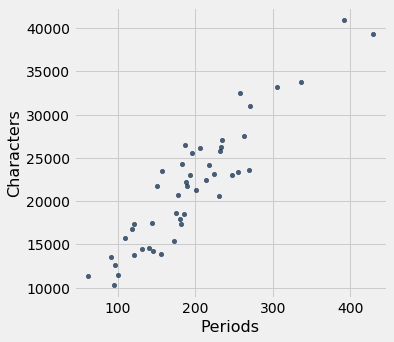

In [5]:
little_women.scatter('Periods', 'Characters')

To explore the data, we will need to use the functions `correlation`, `slope`, `intercept`, and `fit` defined in the previous section.

In [6]:
correlation(little_women, 'Periods', 'Characters')

0.9229576895854817

The scatter plot is remarkably close to linear, and the correlation is more than 0.92.

### Error in Estimation ###

The graph below shows the scatter plot and line that we developed in the previous section. We don't yet know if that's the best among all lines. We first have to say precisely what "best" means.

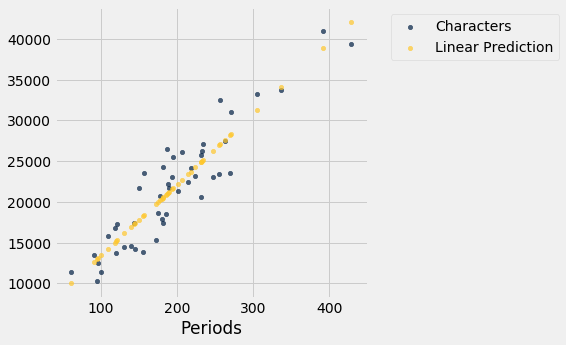

In [7]:
lw_with_predictions = little_women.with_column('Linear Prediction', fit(little_women, 'Periods', 'Characters'))
lw_with_predictions.scatter('Periods')

Corresponding to each point on the scatter plot, there is an error of prediction calculated as the actual value minus the predicted value. It is the vertical distance between the point and the line, with a negative sign if the point is below the line.

In [8]:
actual = lw_with_predictions.column('Characters')
predicted = lw_with_predictions.column('Linear Prediction')
errors = actual - predicted

In [9]:
lw_with_predictions.with_column('Error', errors)

Periods,Characters,Linear Prediction,Error
189,21759,21183.6,575.403
188,22148,21096.6,1051.38
231,20558,24836.7,-4278.67
195,25526,21705.5,3820.54
255,23395,26924.1,-3529.13
140,14622,16921.7,-2299.68
131,14431,16138.9,-1707.88
214,22476,23358,-882.043
337,33767,34056.3,-289.317
185,18508,20835.7,-2327.69


We can use `slope` and `intercept` to calculate the slope and intercept of the fitted line. The graph below shows the line (in light blue). The errors corresponding to four of the points are shown in red. There is nothing special about those four points. They were just chosen for clarity of the display. The function `lw_errors` takes a slope and an intercept (in that order) as its arguments and draws the figure. 

In [10]:
lw_reg_slope = slope(little_women, 'Periods', 'Characters')
lw_reg_intercept = intercept(little_women, 'Periods', 'Characters')

In [11]:
# HIDDEN

sample = [[131, 14431], [231, 20558], [392, 40935], [157, 23524]]
def lw_errors(slope, intercept):
    little_women.scatter('Periods', 'Characters')
    xlims = np.array([50, 450])
    plots.plot(xlims, slope * xlims + intercept, lw=2)
    for x, y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=2)

Slope of Regression Line:     87.0 characters per period
Intercept of Regression Line: 4745.0 characters


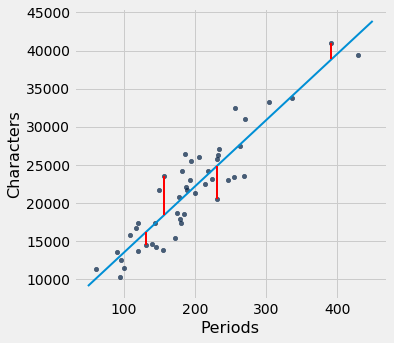

In [12]:
print('Slope of Regression Line:    ', np.round(lw_reg_slope), 'characters per period')
print('Intercept of Regression Line:', np.round(lw_reg_intercept), 'characters')
lw_errors(lw_reg_slope, lw_reg_intercept)

Had we used a different line to create our estimates, the errors would have been different. The graph below shows how big the errors would be if we were to use another line for estimation. The second graph shows large errors obtained by using a line that is downright silly.

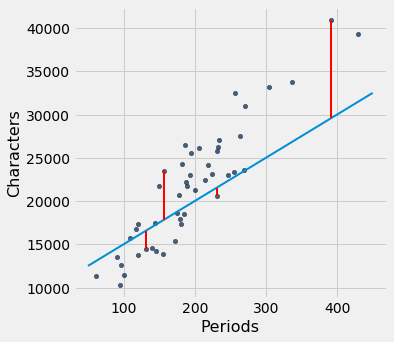

In [13]:
lw_errors(50, 10000)

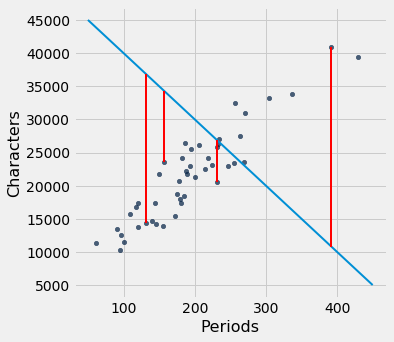

In [14]:
lw_errors(-100, 50000)

### Root Mean Squared Error ###

What we need now is one overall measure of the rough size of the errors. You will recognize the approach to creating this – it's exactly the way we developed the SD.

If you use any arbitrary line to calculate your estimates, then some of your errors are likely to be positive and others negative. To avoid cancellation when measuring the rough size of the errors, we will take the mean of the squared errors rather than the mean of the errors themselves. 

The mean squared error of estimation is a measure of roughly how big the squared errors are, but as we have noted earlier, its units are hard to interpret. Taking the square root yields the root mean square error (rmse), which is in the same units as the variable being predicted and therefore much easier to understand. 

### Minimizing the Root Mean Squared Error ###

Our observations so far can be summarized as follows.

- To get estimates of $y$ based on $x$, you can use any line you want.
- Every line has a root mean squared error of estimation.
- "Better" lines have smaller errors.

Is there a "best" line? That is, is there a line that minimizes the root mean squared error among all lines? 

To answer this question, we will start by defining a function `lw_rmse` to compute the root mean squared error of any line through the Little Women scatter diagram. The function takes the slope and the intercept (in that order) as its arguments.

In [15]:
def lw_rmse(slope, intercept):
    lw_errors(slope, intercept)
    x = little_women.column('Periods')
    y = little_women.column('Characters')
    fitted = slope * x + intercept
    mse = np.mean((y - fitted) ** 2)
    print("Root mean squared error:", mse ** 0.5)

Root mean squared error: 4322.167831766537


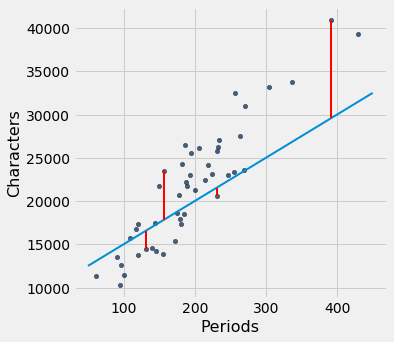

In [16]:
lw_rmse(50, 10000)

Root mean squared error: 16710.11983735375


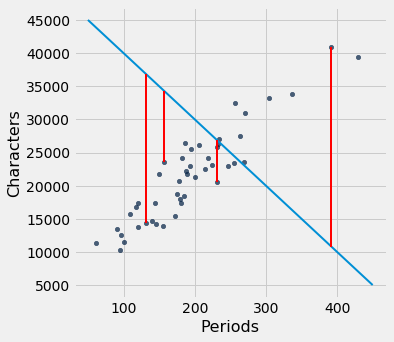

In [17]:
lw_rmse(-100, 50000)

Bad lines have big values of rmse, as expected. But the rmse is much smaller if we choose a slope and intercept close to those of the regression line.

Root mean squared error: 2715.5391063834586


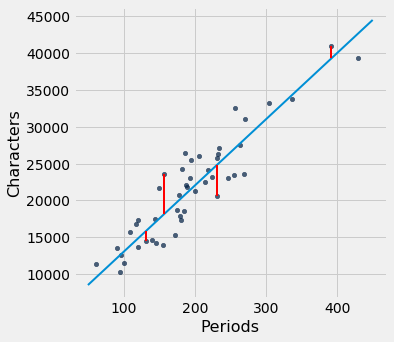

In [18]:
lw_rmse(90, 4000)

Here is the root mean squared error corresponding to the regression line. By a remarkable fact of mathematics, no other line can beat this one. 

- **The regression line is the unique straight line that minimizes the mean squared error of estimation among all straight lines.**

Root mean squared error: 2701.690785311856


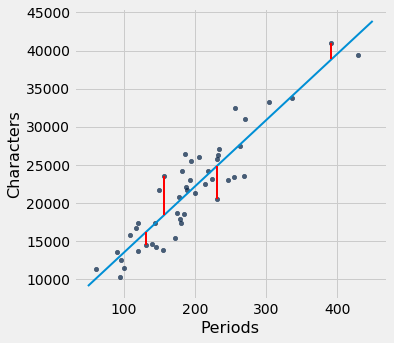

In [19]:
lw_rmse(lw_reg_slope, lw_reg_intercept)

The proof of this statement requires abstract mathematics that is beyond the scope of this course. On the other hand, we do have a powerful tool – Python – that performs large numerical computations with ease. So we can use Python to confirm that the regression line minimizes the mean squared error.

### Numerical Optimization ###
First note that a line that minimizes the root mean squared error is also a line that minimizes the squared error. The square root makes no difference to the minimization. So we will save ourselves a step of computation and just minimize the mean squared error (mse).

We are trying to predict the number of characters ($y$) based on the number of periods ($x$) in chapters of Little Women. If we use the line 
$$
\mbox{prediction} ~=~ ax + b
$$
it will have an mse that depends on the slope $a$ and the intercept $b$. The function `lw_mse` takes the slope and intercept as its arguments and returns the corresponding mse.

In [20]:
def lw_mse(any_slope, any_intercept):
    x = little_women.column('Periods')
    y = little_women.column('Characters')
    fitted = any_slope*x + any_intercept
    return np.mean((y - fitted) ** 2)

Let's check that `lw_mse` gets the right answer for the root mean squared error of the regression line. Remember that `lw_mse` returns the mean squared error, so we have to take the square root to get the rmse.

In [21]:
lw_mse(lw_reg_slope, lw_reg_intercept)**0.5

2701.690785311856

That's the same as the value we got by using `lw_rmse` earlier:

Root mean squared error: 2701.690785311856


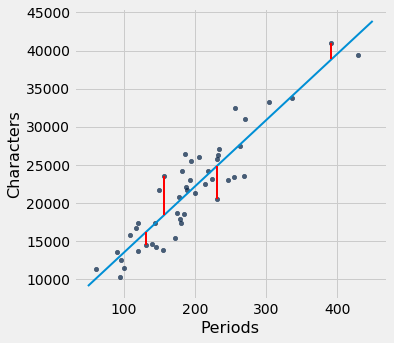

In [22]:
lw_rmse(lw_reg_slope, lw_reg_intercept)

You can confirm that `lw_mse` returns the correct value for other slopes and intercepts too. For example, here is the rmse of the extremely bad line that we tried earlier.

In [23]:
lw_mse(-100, 50000)**0.5

16710.11983735375

And here is the rmse for a line that is close to the regression line.

In [24]:
lw_mse(90, 4000)**0.5

2715.5391063834586

If we experiment with different values, we can find a low-error slope and intercept through trial and error, but that would take a while. Fortunately, there is a Python function that does all the trial and error for us.

The `minimize` function can be used to find the arguments of a function for which the function returns its minimum value. Python uses a similar trial-and-error approach, following the changes that lead to incrementally lower output values. 

The argument of `minimize` is a function that itself takes numerical arguments and returns a numerical value. For example, the function `lw_mse` takes a numerical slope and intercept as its arguments and returns the corresponding mse. 

The call `minimize(lw_mse)` returns an array consisting of the slope and the intercept that minimize the mse. These minimizing values are excellent approximations arrived at by intelligent trial-and-error, not exact values based on formulas.

In [25]:
best = minimize(lw_mse)
best

array([  86.9778415 , 4744.78474903])

These values are the same as the values we calculated earlier by using the `slope` and `intercept` functions. We see small deviations due to the inexact nature of `minimize`, but the values are essentially the same.

In [26]:
print("slope from formula:        ", lw_reg_slope)
print("slope from minimize:       ", best.item(0))
print("intercept from formula:    ", lw_reg_intercept)
print("intercept from minimize:   ", best.item(1))

slope from formula:         86.97784125829823
slope from minimize:        86.97784150241432
intercept from formula:     4744.784796574924
intercept from minimize:    4744.784749026708


### The Least Squares Line ###

Therefore, we have found not only that the regression line minimizes mean squared error, but also that minimizing mean squared error gives us the regression line. The regression line is the only line that minimizes mean squared error.

That is why the regression line is sometimes called the "least squares line."